origin: http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html  
translator: Hongpu Liu

In [1]:
%matplotlib inline

# 数据的加载与处理教程
解决任何机器学习问题都要花费大量的努力在准备数据上。PyTorch提供了很多简化数据加载的工具，增加代码的可读性。本教程中将会加载并预处理来自一个不常见的数据集的数据。

要执行本教程，需要安装以下的软件包：
- **scikit-image**：用于图像的输入/输出和变换
- **pandas**：简化csv文件的解析

In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# 忽略警告
import warnings
warnings.filterwarnings("ignore")

plt.ion() # 交互模式

本教程要处理的数据集是面部位姿，意味着面部会如下图所示进行标注：

![](./imgs/landmarked_face2.png)

每张脸上总共标注68个不同的特征点。

> **注意**
> 数据集从[这里](https://download.pytorch.org/tutorial/faces.zip)下载，图像全部存放于目录**faces/**。该数据集的图像来自ImageNet中标签为**face**的少量图像，标注点用**[dlib's pose estimation](http://blog.dlib.net/2014/08/real-time-face-pose-estimation.html)**生成。

标注点数据集存储与**csv**文件，具有如下的格式：
``` csv
image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y
0805personali01.jpg,27,83,27,98, ... 84,134
1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312
```

接下来快速读入**csv**文件，并将标注点存储到**(N, 2)**维数组中，N为标志点的数量（68个）。

In [3]:
landmards_frame = pd.read_csv('faces/face_landmarks.csv')

# 输出第n幅图像的信息
n = 12
img_name = landmards_frame.iloc[n, 0]
landmarks = landmards_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: 2173711035_dbd53b4f9f.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 28. 127.]
 [ 29. 172.]
 [ 34. 214.]
 [ 42. 255.]]


下面实现函数来显示图像及其人脸特征点，后面会用该函数显示样本。

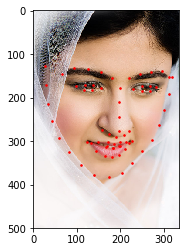

In [4]:
def show_landmarks(image, landmarks):
    """显示图像与特征点"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    # plt.pause(0.001) # 暂停片刻等待绘图更新
    
plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)), landmarks)
plt.show()

## 1. Dataset类
**torch.utils.data.Dataset**是一个用来表示数据集的抽象类。自定义数据集需要继承**Dataset**并覆盖以下方法：
- **`__len__`**：以保证调用**len(dataset)**可以返回数据集的大小。
- **`__getitem__`**：用于支持类似**dateset[i]**这样的索引操作，**dateset[i]**要返回第i个样本。

下面为面部特征点创建一个**dataset**类。我们将在**`__init__`**当中读取**csv**文件，并在**`__getitem__`**中读取图像。这种设计在需要时读取图像，而不是把图像存储在内存中，因此空间复杂度低。

数据集的样本是一个词典：**{'image': image, 'landmarks': landmarks}**。我们的数据集有一个可选参数：**transform**，该参数可以把需要的处理应用到样本上。在一下节将会看到**transform**的用处。

In [5]:
class FaceLandmarksDataset(Dataset):
    """人脸特征点数据集"""
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        参数：
            csv_file (string): 存储标记数据的csv文件的路径
            root_dir (string): 图像所在路径
            transform (callable, optional): 可选的应用于样本的变换
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                               self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

下面实例化上面定义的类，并利用该实例迭代获得数据样本。下面的例子输出前4个样本的尺寸，并显示图像及特征点。

0 (324, 215, 3) (68, 2)
1 (500, 333, 3) (68, 2)
2 (250, 258, 3) (68, 2)
3 (434, 290, 3) (68, 2)
4 (828, 630, 3) (68, 2)
5 (402, 500, 3) (68, 2)
6 (332, 500, 3) (68, 2)
7 (333, 500, 3) (68, 2)


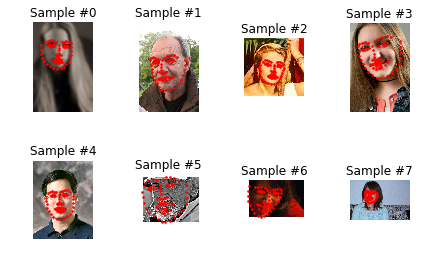

In [6]:
face_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                    root_dir='faces/')
fig = plt.figure

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    
    print(i, sample['image'].shape, sample['landmarks'].shape)
    
    ax = plt.subplot(2, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)
    
    if i == 7:
        plt.show()
        break

## 2. 变换（Transform）
从前面的样本中可以看到样本的图像尺寸并不一样。而大部分的神经网络需要固定尺寸的输入。因此，我们需要编写处理代码。下面将实现三个变换：
- **Rescale**：缩放图像
- **RandomCrop**：对图像进行随机裁剪，这是一种数据增广技术
- **ToTensor**：将numpy图像转换为PyTorch图像（需要交换数据轴）

我们将它们编写为可调用的类而不是函数，这是因为函数调用每一次都需要传入参数。为了实现这一目标，我们需要实现**`__call__`**方法，若需要还要创建**`__init__`**方法。然后就可以以如下的方式使用变换：

``` Python
tfsm = Transform(params)
transformed_sample = tfsm(sample)
```

注意下面的代码是如何讲变换同时应用到图像和特征点上：

In [7]:
class Rescale(object):
    """ 将样本缩放为制定的尺寸
    
    参数：
        output_size (tuple or int)：输出的尺寸。如果是元组，输出匹配output_size。
            如果是int，令图像的短边匹配output_size，同时保持纵横比。
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
            
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))
        
        # 特征点的h和w要交换，因为特征点的x和y分别是第1个轴和第0个轴
        landmarks = landmarks * [new_w / w, new_h / h]
        
        return {'image': img, 'landmarks':landmarks}
    
class RandomCrop(object):
    """ 对样本中的图像进行随机裁剪
    
    参数：
        output_size (tuple or int): 输出图像的尺寸。若是整数则裁剪为正方形。
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
            
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top: top + new_h,
                     left: left + new_w]
        
        landmarks = landmarks - [left, top]
        
        return {'image': image, 'landmarks': landmarks}

class ToTensor(object):
    """将样本由N维数组变换为Tensor"""
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        # 对张量进行转置，因为：
        # numpy图像： H x W x C
        # torch图像： H x W x C
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
               'landmarks': torch.from_numpy(landmarks)}

### 2.1 组合变换
现在让我们将变换应用到样本上。

例如，我们要把图像的短边缩小到256，然后随机裁剪边长为224的正方形图像。也就是说需要组合**Rescale**和**RandomCrop**变换。**torchvision.transforms.Compose**是一个用来组合变换的可调用类。

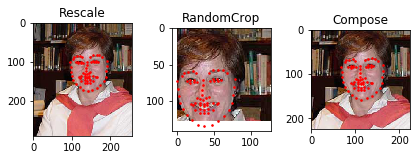

In [8]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                              RandomCrop(224)])

# 将每一种变换应到样本上
fig = plt.figure
sample = face_dataset[66]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

## 3. 对数据集进行迭代
接下来将把创建数据集和组合变换结合到一起。简单的说，就是每一次都对数据集进行采样：
- 图像在运行时从文件读取
- 将变换应用到读入的图像上
- 由于有一步变换是随机的，因此数据在采样的时候进行了增广

我们可以用**for i in range**迭代数据集。

In [9]:
transformed_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                           root_dir='faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    
    print(i, sample['image'].size(), sample['landmarks'].size())
    
    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


然而，在使用**for**循环来迭代数据时，缺失了很多的特性。在实践中，我们还需要：
- 批量数据
- 打乱数据
- 利用**multiprocessing**并行载入数据

**torch.utils.data.DataLoader**是一个提供以上特性的迭代器，构造函数中的大部分参数的功能一目了然。其中一个比较有趣的参数是**collate_fn**，该参数可以精确的指定批量数据中的样本。然而，默认的**collate**在大部分应用场景工作效果不错。

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


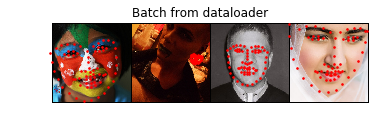

In [10]:
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4)

# 显示批量样本的Helper
def show_landmarks_batch(sample_batched):
    """显示批量样本的图像和特征点"""
    images_batch, landmarks_batch = sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')
        plt.title('Batch from dataloader')
    
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())
    
    # 观察第四批然后停止
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

## 4. 后记：torchvision
在本教程中，我们看到了如何编写和使用自定义的数据集、变换和加载器。**torchvision**包提供了一些通用的数据集和变换。你也许并不需要编写自定义的类。**torchvision**中一个非常通用的数据集叫做**ImageFolder**。它假设图像以下面的形式进行整理：
```
root/ants/xxx.png
root/ants/xxy.jpeg
root/ants/xxz.png
.
.
.
root/bees/123.jpg
root/bees/nsdf3.png
root/bees/asd932_.png
```

其中**ants**和**bees**是类标签。在**PIL.Image**上进行类似**RandomHorizontalFlip**、**Scale**都是可用的。可以利用这些内置的功能来定义数据加载器：

In [11]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

hymenoptera_dataset = datasets.ImageFolder(root='../03_Transfer_Learning_Tutorial/hymenoptera_data/train',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)